# Automated Essay Scoring 

### What is this Notebook about?

- This Notebook contains all raw results and experiments done with the various deep learning methods. The output cells contains the results that we got. The whole Notebook may take approximately 5-6 hours. This Notebook contains the following:

* Preprocess data
* Important util methods to be used later
* Deep Learning Model declaration
* Running bert for individual sets
* Running bert for whole dataset
* Running word2vec for individual sets
* Running word2vec for whole dataset

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

Init Plugin
Init Graph Optimizer
Init Kernel
2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
import sys
!{sys.executable} -m pip install transformers

  Using cached transformers-4.17.0-py3-none-any.whl (3.8 MB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached filelock-3.6.0-py3-none-any.whl (10.0 kB)
  Using cached tokenizers-0.11.6-cp39-cp39-macosx_12_0_arm64.whl (3.4 MB)
  Using cached sacremoses-0.0.49-py3-none-any.whl (895 kB)


In [2]:
# import important libraries and download data
import os
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import multiprocessing
%matplotlib notebook
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
# ! git clone https://github.com/Gaurav-Pande/AES_DL.git && mv AES_DL/data .

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Declaring some visualization methods to plot accuracy and model diagram
def plot_accuracy_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mae'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_acrchitecture(filename, model):
    plot_model(model, to_file=str(filename) + '.png')

In [4]:
# method to split data into sets
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    
    for s in range(1,9):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    
    return (essay_sets, min_scores, max_scores)

In the below cell, we can see the data we need to operate. We essentially drops the column, we dont need and keep the domain_score only along with essay text.

In [5]:
dataset_path = "./data/training_set_rel3.tsv"
data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1")
min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]
essay_sets, data_min_scores, data_max_scores = split_in_sets(data)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)
data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set1.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set2.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set3.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set4.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set5.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set6.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set7.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set8.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
sets = [set1,set2,set3,set4,set5,set6,set7,set8]
data.head()

Set 1 : Essays =  1783 	 Attributes =  6
Set 2 : Essays =  1800 	 Attributes =  9
Set 3 : Essays =  1726 	 Attributes =  6
Set 4 : Essays =  1770 	 Attributes =  6
Set 5 : Essays =  1805 	 Attributes =  6
Set 6 : Essays =  1800 	 Attributes =  6
Set 7 : Essays =  1569 	 Attributes =  14
Set 8 : Essays =  723 	 Attributes =  18


/Users/SonTungKieu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/SonTungKieu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


 There are named entity tags as you can see above, which can impact our model. so we need to remove them from the dataframe. So we will extend our stopwords set later on. But first we need to create all possible ner tags.

In [6]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

Some utility functions declarations needed to convert the raw essay to word list.

In [7]:
import collections
top10 = collections.defaultdict(int)
def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    #top10 = collections.defaultdict(int)
    if remove_stopwords:
        stops = stopwords.words("english")
        stops.extend(ner)
        for word in words:
          if word not in stops:
            # words.append(w)
            top10[word]+=1
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

Below we declare the model. here the model is of older version. for running the most recent version please refer to readme, which inputs the model_type as well in terms of hyperparameter.

In [8]:
from keras.layers import Embedding, Input, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional, Conv2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential,Model, load_model, model_from_config
import keras.backend as K

def get_model(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768, activation='relu', bidirectional = False):
    """Define the model."""
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(Hidden_dim1,return_sequences=return_sequences , dropout=0.4, recurrent_dropout=recurrent_dropout), input_shape=[1, input_size]))
        model.add(Bidirectional(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout)))
    else:
        model.add(LSTM(Hidden_dim1, dropout=0.4, recurrent_dropout=recurrent_dropout, input_shape=[1, input_size], return_sequences=return_sequences))
        model.add(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
    model.summary()
    
    return model

def get_model_CNN(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768,output_dims=10380, activation='relu', bidirectional = False):
   
    """Define the model."""
    inputs = Input(shape=(768,1))
    x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)
    
    #Cuts the size of the output in half, maxing over every 2 inputs
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
    x = GlobalMaxPooling1D()(x) 
    outputs = Dense(output_dims, activation='relu')(x)
    model = Model(inputs=inputs, outputs=outputs, name='CNN')
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse'])
    model.summary()
    
    return model

Below we will run the model for all sets using BERT

In [9]:
## Sets experiment BERT
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []

for s in sets:
    print("\n--------SET {}--------\n".format(set_count))
    X = s
    y = s['domain1_score']
    cv = KFold(n_splits=5, shuffle=True)
    cv_data = cv.split(X)
    results = []
    prediction_list = []
    fold_count =1
#     cuda = torch.device('cuda')
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#     model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    for traincv, testcv in cv_data:
        torch.cuda.empty_cache()
        print("\n--------Fold {}--------\n".format(fold_count))

        # get the train and test from the dataset.
        X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
        train_essays = X_train['essay']
        test_essays = X_test['essay']

        sentences = []
        tokenize_sentences = []
        train_bert_embeddings = []
        #bert_embedding = BertEmbedding()
        # for essay in train_essays:
        #   # get all the sentences from the essay
        #   sentences += essay_to_sentences(essay, remove_stopwords = True)
        # sentences = pd.Series(sentences)
        # print(train_essays)
        tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))
        tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))


        ## train
        max_len = 0
        for i in tokenized_train.values:
            if len(i) > max_len:
                max_len = len(i)

        padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])
        attention_mask_train = np.where(padded_train != 0, 1, 0)
        train_input_ids = torch.tensor(padded_train)
        train_attention_mask = torch.tensor(attention_mask_train)

        with torch.no_grad():
            last_hidden_states_train = model(train_input_ids, attention_mask=train_attention_mask)

        train_features = last_hidden_states_train[0][:,0,:].numpy()


        ## test
        max_len = 0
        for i in tokenized_test.values:
            if len(i) > max_len:
                max_len = len(i)

        padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
        attention_mask_test = np.where(padded_test != 0, 1, 0)
        test_input_ids = torch.tensor(padded_test)  
        test_attention_mask = torch.tensor(attention_mask_test)

        with torch.no_grad():
            last_hidden_states_test = model(test_input_ids, attention_mask=test_attention_mask)

        test_features = last_hidden_states_test[0][:,0,:].numpy()


        train_x, train_y = train_features.shape
        test_x, test_y = test_features.shape

        trainDataVectors = np.reshape(train_features,(train_x, 1, train_y))
        testDataVectors = np.reshape(test_features,(test_x, 1, test_y))

        # LSTM Model
        lstm_model = get_model(bidirectional=False)
        lstm_model.fit(trainDataVectors, y_train, batch_size=128, epochs=70)
        y_pred = lstm_model.predict(testDataVectors)
        y_pred = np.around(y_pred)
        #y_pred.dropna()
        np.nan_to_num(y_pred)

        # evaluate the model
        result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
        print("Kappa Score: {}".format(result))
        results.append(result)
        fold_count +=1

        tf.keras.backend.clear_session()

        all_sets_score.append(results)
        
    print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
    set_count+=1
        # print(features.shape)


--------SET 1--------



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the 


--------Fold 1--------

Metal device set to: Apple M1 Pro


2022-04-21 19:34:16.360895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-21 19:34:16.361338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 400)            1870400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


2022-04-21 19:34:16.786449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-21 19:34:16.787690: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-21 19:34:26.827256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 11s 47ms/step - loss: 34.8818 - mse: 34.8818
Epoch 2/70
12/12 [==============================] - 0s 36ms/step - loss: 2.7479 - mse: 2.7479
Epoch 3/70
12/12 [==============================] - 0s 36ms/step - loss: 2.5996 - mse: 2.5996
Epoch 4/70
12/12 [==============================] - 0s 36ms/step - loss: 2.4061 - mse: 2.4061
Epoch 5/70
12/12 [==============================] - 0s 37ms/step - loss: 2.1586 - mse: 2.1586
Epoch 6/70
12/12 [==============================] - 0s 36ms/step - loss: 2.4061 - mse: 2.4061
Epoch 7/70
12/12 [==============================] - 0s 37ms/step - loss: 1.9751 - mse: 1.9751
Epoch 8/70
12/12 [==============================] - 0s 36ms/step - loss: 2.0603 - mse: 2.0603
Epoch 9/70
12/12 [==============================] - 0s 36ms/step - loss: 1.9751 - mse: 1.9751
Epoch 10/70
12/12 [==============================] - 0s 35ms/step - loss: 1.9513 - mse: 1.9513
Epoch 11/70
12/12 [==============================] - 0s 35ms/step -

2022-04-21 19:34:58.607627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Kappa Score: 0.5252537955801491

--------Fold 2--------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 400)            1870400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


2022-04-21 19:36:16.243103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 3s 46ms/step - loss: 36.3220 - mse: 36.3220
Epoch 2/70
12/12 [==============================] - 0s 36ms/step - loss: 2.8215 - mse: 2.8215
Epoch 3/70
12/12 [==============================] - 0s 37ms/step - loss: 2.4573 - mse: 2.4573
Epoch 4/70
12/12 [==============================] - 0s 36ms/step - loss: 2.4127 - mse: 2.4127
Epoch 5/70
12/12 [==============================] - 0s 36ms/step - loss: 2.1041 - mse: 2.1041
Epoch 6/70
12/12 [==============================] - 0s 36ms/step - loss: 1.9070 - mse: 1.9070
Epoch 7/70
12/12 [==============================] - 0s 36ms/step - loss: 1.7975 - mse: 1.7975
Epoch 8/70
12/12 [==============================] - 0s 36ms/step - loss: 1.9185 - mse: 1.9185
Epoch 9/70
12/12 [==============================] - 0s 36ms/step - loss: 1.8837 - mse: 1.8837
Epoch 10/70
12/12 [==============================] - 0s 36ms/step - loss: 1.7656 - mse: 1.7656
Epoch 11/70
12/12 [==============================] - 0s 36ms/step - 

2022-04-21 19:36:47.731408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Kappa Score: 0.634962514040908

--------Fold 3--------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 400)            1870400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


2022-04-21 19:38:02.573698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 3s 48ms/step - loss: 34.3119 - mse: 34.3119
Epoch 2/70
12/12 [==============================] - 0s 37ms/step - loss: 2.7463 - mse: 2.7463
Epoch 3/70
12/12 [==============================] - 0s 36ms/step - loss: 2.4653 - mse: 2.4653
Epoch 4/70
12/12 [==============================] - 0s 37ms/step - loss: 2.5188 - mse: 2.5188
Epoch 5/70
12/12 [==============================] - 0s 37ms/step - loss: 2.1612 - mse: 2.1612
Epoch 6/70
12/12 [==============================] - 0s 37ms/step - loss: 2.0373 - mse: 2.0373
Epoch 7/70
12/12 [==============================] - 0s 37ms/step - loss: 1.9856 - mse: 1.9856
Epoch 8/70
12/12 [==============================] - 0s 36ms/step - loss: 1.6763 - mse: 1.6763
Epoch 9/70
12/12 [==============================] - 0s 36ms/step - loss: 1.8606 - mse: 1.8606
Epoch 10/70
12/12 [==============================] - 0s 36ms/step - loss: 1.8090 - mse: 1.8090
Epoch 11/70
12/12 [==============================] - 0s 36ms/step - 

2022-04-21 19:38:34.619972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Kappa Score: 0.6321768862548438

--------Fold 4--------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 400)            1870400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


2022-04-21 19:39:49.966324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 3s 50ms/step - loss: 35.1041 - mse: 35.1041
Epoch 2/70
12/12 [==============================] - 0s 37ms/step - loss: 2.9698 - mse: 2.9698
Epoch 3/70
12/12 [==============================] - 0s 38ms/step - loss: 2.5777 - mse: 2.5777
Epoch 4/70
12/12 [==============================] - 0s 38ms/step - loss: 2.4821 - mse: 2.4821
Epoch 5/70
12/12 [==============================] - 0s 37ms/step - loss: 2.1365 - mse: 2.1365
Epoch 6/70
12/12 [==============================] - 0s 36ms/step - loss: 1.9852 - mse: 1.9852
Epoch 7/70
12/12 [==============================] - 0s 36ms/step - loss: 1.9104 - mse: 1.9104
Epoch 8/70
12/12 [==============================] - 0s 37ms/step - loss: 1.7911 - mse: 1.7911
Epoch 9/70
12/12 [==============================] - 0s 37ms/step - loss: 1.9611 - mse: 1.9611
Epoch 10/70
12/12 [==============================] - 0s 37ms/step - loss: 1.7819 - mse: 1.7819
Epoch 11/70
12/12 [==============================] - 0s 36ms/step - 

2022-04-21 19:40:21.808776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Kappa Score: 0.4799826877299286

--------Fold 5--------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 400)            1870400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


2022-04-21 19:41:45.645003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 5s 48ms/step - loss: 35.1881 - mse: 35.1881
Epoch 2/70
12/12 [==============================] - 0s 37ms/step - loss: 2.8187 - mse: 2.8187
Epoch 3/70
12/12 [==============================] - 0s 36ms/step - loss: 2.7020 - mse: 2.7020
Epoch 4/70
12/12 [==============================] - 0s 37ms/step - loss: 2.2343 - mse: 2.2343
Epoch 5/70
12/12 [==============================] - 0s 37ms/step - loss: 2.4121 - mse: 2.4121
Epoch 6/70
12/12 [==============================] - 0s 37ms/step - loss: 2.3527 - mse: 2.3527
Epoch 7/70
12/12 [==============================] - 0s 37ms/step - loss: 1.9909 - mse: 1.9909
Epoch 8/70
12/12 [==============================] - 0s 37ms/step - loss: 2.4387 - mse: 2.4387
Epoch 9/70
12/12 [==============================] - 0s 36ms/step - loss: 1.8608 - mse: 1.8608
Epoch 10/70
12/12 [==============================] - 0s 35ms/step - loss: 1.7213 - mse: 1.7213
Epoch 11/70
12/12 [==============================] - 0s 36ms/step - 

2022-04-21 19:42:21.083295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Kappa Score: 0.6178508043739623
Average kappa score value is : 0.5780453375959583

--------SET 2--------



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the 


--------Fold 1--------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 400)            1870400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               270848    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


2022-04-21 19:44:07.407978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 4s 60ms/step - loss: 4.8462 - mse: 4.8462
Epoch 2/70
12/12 [==============================] - 1s 44ms/step - loss: 0.6871 - mse: 0.6871
Epoch 3/70
12/12 [==============================] - 1s 43ms/step - loss: 0.5731 - mse: 0.5731
Epoch 4/70
12/12 [==============================] - 1s 43ms/step - loss: 0.6072 - mse: 0.6072
Epoch 5/70
12/12 [==============================] - 1s 43ms/step - loss: 0.5513 - mse: 0.5513
Epoch 6/70
12/12 [==============================] - 1s 43ms/step - loss: 0.5078 - mse: 0.5078
Epoch 7/70
12/12 [==============================] - 1s 44ms/step - loss: 0.5391 - mse: 0.5391
Epoch 8/70
12/12 [==============================] - 1s 43ms/step - loss: 0.4444 - mse: 0.4444
Epoch 9/70
12/12 [==============================] - 1s 43ms/step - loss: 0.4518 - mse: 0.4518
Epoch 10/70
12/12 [==============================] - 1s 43ms/step - loss: 0.4369 - mse: 0.4369
Epoch 11/70
12/12 [==============================] - 1s 43ms/step - lo

KeyboardInterrupt: 



--------Fold 1--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10380/10380 [==============================] - 5s 527us/step - loss: 38.7916 - mae: 3.4809 - mse: 38.7916
Epoch 2/100
10380/10380 [==============================] - 4s 357us/step - loss: 22.0969 - mae: 2.

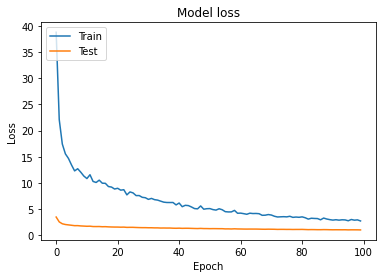

[[ 9.]
 [ 8.]
 [ 9.]
 ...
 [38.]
 [29.]
 [38.]]
Kappa Score: 0.9239790570710182

--------Fold 2--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 522us/step - loss: 40.6611 - mae: 3.5470 - mse: 40.6611
Epoch 2/100
10381/1

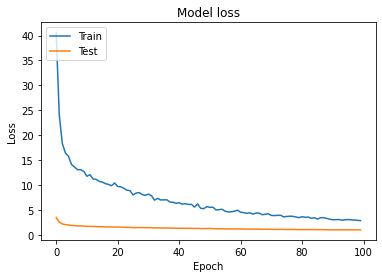

[[ 8.]
 [ 9.]
 [10.]
 ...
 [26.]
 [29.]
 [ 5.]]
Kappa Score: 0.9450567379796316

--------Fold 3--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 504us/step - loss: 39.2819 - mae: 3.4838 - mse: 39.2819
Epoch 2/100
10381/1

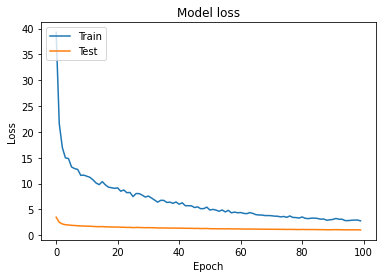

[[ 8.]
 [ 9.]
 [ 8.]
 ...
 [41.]
 [30.]
 [34.]]
Kappa Score: 0.9256860865252433

--------Fold 4--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 505us/step - loss: 37.7470 - mae: 3.4443 - mse: 37.7470
Epoch 2/100
10381/1

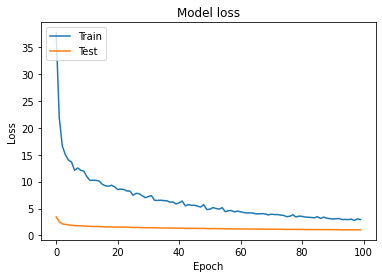

[[ 9.]
 [10.]
 [ 6.]
 ...
 [42.]
 [35.]
 [10.]]
Kappa Score: 0.9236147722479966

--------Fold 5--------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            2565600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10381/10381 [==============================] - 5s 502us/step - loss: 38.7174 - mae: 3.4607 - mse: 38.7174
Epoch 2/100
10381/1

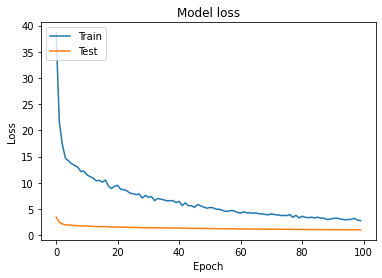

[[ 9.]
 [ 9.]
 [11.]
 ...
 [16.]
 [20.]
 [20.]]
Kappa Score: 0.9193338813957616
Average kappa score value is : 0.9275341070439304


In [12]:
 # For whole dataset
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

cv = KFold(n_splits=5, shuffle=True)
X = data
y = data['domain1_score']
cv_data = cv.split(X)
results = []
prediction_list = []
fold_count = 1

# Hyperpaprameters for LSTM
Hidden_dim1 = 300
Hidden_dim2 = 100
return_sequences = True
dropout = 0.5
recurrent_dropout = 0.4
input_size = 768
activation = 'relu'
bidirectional = True
batch_size = 64
epoch = 100
#####

# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
## Want BERT instead of distilBERT? Uncomment the following line:
##model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

for traincv, testcv in cv_data:
    torch.cuda.empty_cache()
    print("\n--------Fold {}--------\n".format(fold_count))
    # get the train and test from the dataset.
    X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
    train_essays = X_train['essay']
    #print("y_train",y_train)
    test_essays = X_test['essay']
    # model = model.cuda()
    #y_train = torch.tensor(y_train,dtype=torch.long)
    sentences = []
    tokenize_sentences = []
    train_bert_embeddings = []
    #bert_embedding = BertEmbedding()
    # for essay in train_essays:
    #   # get all the sentences from the essay
    #   sentences += essay_to_sentences(essay, remove_stopwords = True)
    # sentences = pd.Series(sentences)
    # print(train_essays)
    tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=55)))
    tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=55)))


    ## train
    max_len = 0
    for i in tokenized_train.values:
        if len(i) > max_len:
            max_len = len(i)
    padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

    attention_mask_train = np.where(padded_train != 0, 1, 0)



    train_input_ids = torch.tensor(padded_train)
    train_attention_mask = torch.tensor(attention_mask_train)
    with torch.no_grad():
        last_hidden_states_train = model(train_input_ids, attention_mask=train_attention_mask)


    train_features = last_hidden_states_train[0][:,0,:].numpy()


    ## test
    max_len = 0
    for i in tokenized_test.values:
        if len(i) > max_len:
            max_len = len(i)
    padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
    attention_mask_test = np.where(padded_test != 0, 1, 0)
    test_input_ids = torch.tensor(padded_test)  
    test_attention_mask = torch.tensor(attention_mask_test)

    with torch.no_grad():
        last_hidden_states_test = model(test_input_ids, attention_mask=test_attention_mask)

    test_features = last_hidden_states_test[0][:,0,:].numpy()
    train_x,train_y = train_features.shape
    test_x,test_y = test_features.shape
    trainDataVectors = np.reshape(train_features,(train_x,1,train_y))
    testDataVectors = np.reshape(test_features,(test_x,1,test_y))
    # print(trainDataVectors)
    # print(testDataVectors)
    # trainDataVectors = np.reshape(train_features,(train_x,train_y,1))
    # testDataVectors = np.reshape(test_features,(test_x,test_y,1))
    trainDataVectors = np.reshape(train_features,(train_x,1, train_y))
    testDataVectors = np.reshape(test_features,(test_x,1, test_y))
    # lstm_model = get_model_CNN(bidirectional=False, output_dims = 1)
    lstm_model = get_model(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                            dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                            activation=activation, bidirectional=bidirectional)
    history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
    plot_accuracy_curve(history)
    y_pred = lstm_model.predict(testDataVectors)
    y_pred = np.around(y_pred)
    #y_pred.dropna()
    np.nan_to_num(y_pred)
    # evaluate the model
    print(y_pred)
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    fold_count +=1
    import tensorflow as tf
    tf.keras.backend.clear_session()

print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
# print(features.shape)

In [0]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [0]:
trainDataVectors = np.reshape(train_features,(train_x,train_y,1))
testDataVectors = np.reshape(test_features,(test_x,test_y,1))
print(y_train.shape)
print(trainDataVectors.shape)

(10380,)
(10380, 768, 1)


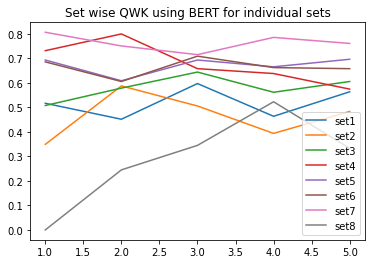

In [0]:
# x = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
def plot_qwk_scores_all_sets():
  fig = plt.figure()
  ax = plt.subplot(111)
  x = [1,2,3,4,5]
  ax.plot(x, set1 , label='set1')
  ax.plot(x, set2, label='set2')
  ax.plot(x, set3, label='set3')
  ax.plot(x, set4, label='set4')
  ax.plot(x, set5, label='set5')
  ax.plot(x, set6, label='set6')
  ax.plot(x, set7, label='set7')
  ax.plot(x, set8, label='set8')
  plt.title('Set wise QWK using BERT for individual sets')
  ax.legend()
  plt.show()


Buildind word2vec model method to render the text and convert to word2vec feature vector.

In [9]:
def build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                     downsampling):
    model = Word2Vec(workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                     sample=downsampling)
    # saving the word2vec model
    # model.wv.save_word2vec_format('word2vec_'+ str(fold_count) +'.bin', binary=True)
    cores = multiprocessing.cpu_count()
    print("\n {} cores using".format(cores))
    start_time = time.time()
    model.build_vocab(train_sentences, progress_per=10000)
    print('Time to build vocab using word2vec: {} sec'.format(time.time() - start_time))
    start_time = time.time()
    model.train(train_sentences, total_examples=model.corpus_count, epochs=epochs, report_delay=1)
    print('Time to train the word2vec model: {} mins'.format(time.time() - start_time))
    model.init_sims(replace=True)
    sorted_dic = sorted(top10.items(), key=lambda k: k[1], reverse=True)
    return model,sorted_dic

Below method will run on individual sets using word2vec

In [11]:
# Individual sets 
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
# Hyperparameters for word2vec
num_features = 400
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3
epochs = 30

# Hyperpaprameters for LSTM
Hidden_dim1=300
Hidden_dim2=100
return_sequences = True
dropout=0.5
recurrent_dropout=0.4
input_size=400
activation='relu'
bidirectional = True
batch_size = 64
epoch = 70
#####
####
import tensorflow as tf
tf.keras.backend.clear_session()

for s in sets:
  print("\n--------SET {}--------\n".format(set_count))
  set_count +=1
  X = s
  y = s['domain1_score']
  cv = KFold(n_splits=5, shuffle=True)
  #X, y = prepare_data(dataset_path=dataset_path)
  cv_data = cv.split(X)
  results = []
  prediction_list = []
  fold_count =1
  # hyperparameters for word2vec
  most_common_words= []
  print(X.shape)
  print(y.shape)
  for traincv, testcv in cv_data:
      print("\n--------Fold {}--------\n".format(fold_count))
      # get the train and test from the dataset.
      X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
      train_essays = X_train['essay']
      #print("y_train",y_train)
      test_essays = X_test['essay']
      #y_train = torch.tensor(y_train,dtype=torch.long)
      train_sentences = []
      # print("train_essay ",train_essays.shape)
      #print(X_train.shape,y_train.shape)
      for essay in train_essays:
          # get all the sentences from the essay
          train_sentences.append(essay_to_wordlist(essay, remove_stopwords = True))

      # word2vec embedding
      print("Converting sentences to word2vec model")
      model,_ = build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                    downsampling)
      top10 = collections.defaultdict(int)

      # print("train_sentencesshap",len(train_sentences))
      trainDataVecs = np.array(getAvgFeatureVecs(train_sentences, model, num_features))
      test_sentences = []
      for essay_v in test_essays:
          test_sentences.append(essay_to_wordlist(essay_v, remove_stopwords=True))
      testDataVecs = np.array(getAvgFeatureVecs(test_sentences, model, num_features))
      trainDataVectors = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
      testDataVectors = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
      lstm_model = get_model(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                              dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                              activation=activation, bidirectional=bidirectional)
      # print(trainDataVectors.shape)
      # print(y_train.shape)
      history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
      plot_accuracy_curve(history)
      y_pred = lstm_model.predict(testDataVectors)
      y_pred = np.around(y_pred)
      np.nan_to_num(y_pred)
      result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
      print("Kappa Score: {}".format(result))
      results.append(result)
      fold_count += 1

  print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
  all_sets_score.append(results)



--------SET 1--------

(1783, 4)
(1783,)

--------Fold 1--------

Converting sentences to word2vec model

 8 cores using
Time to build vocab using word2vec: 0.08371305465698242 sec
Time to train the word2vec model: 3.813648223876953 mins
Metal device set to: Apple M1 Pro


2022-04-26 17:29:36.379478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-26 17:29:36.379577: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

Below method is for running the model on whole dataset using the word2vec model.

(12976, 4)
(12976,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8619236946105957 sec
Time to train the word2vec model: 48.41549491882324 mins
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10380/10380 [==

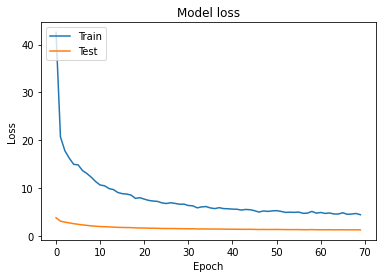

Kappa Score: 0.9690772488848252

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8998920917510986 sec
Time to train the word2vec model: 48.410395860672 mins
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10381

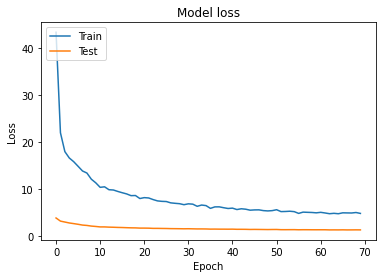

Kappa Score: 0.9723570173189542

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8663942813873291 sec
Time to train the word2vec model: 47.800869941711426 mins
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10

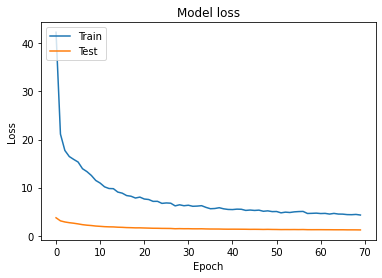

Kappa Score: 0.9681606637795384

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8679554462432861 sec
Time to train the word2vec model: 47.314122915267944 mins
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10

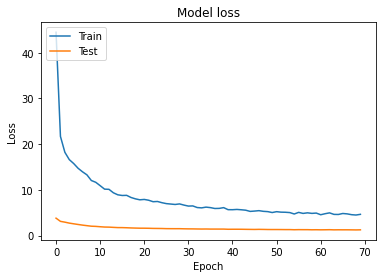

Kappa Score: 0.9725130742146156

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8937320709228516 sec
Time to train the word2vec model: 48.75269365310669 mins
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
103

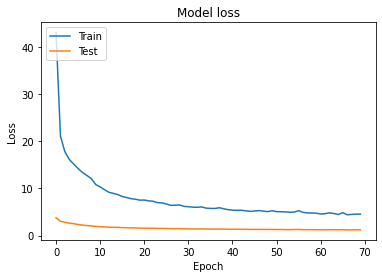

Kappa Score: 0.9569597144906096
Average kappa score value is : 0.9678135437377084


In [0]:
# Whole Dataset Word2vec
X= data
y = data['domain1_score']
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
# Hyperparameters for word2vec
num_features = 400
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3
epochs = 30

# Hyperpaprameters for LSTM
Hidden_dim1=300
Hidden_dim2=100
return_sequences = True
dropout=0.5
recurrent_dropout=0.4
input_size=400
activation='relu'
bidirectional = True
batch_size = 64
epoch = 70
#####
####
import tensorflow as tf
tf.keras.backend.clear_session()
cv = KFold(n_splits=5, shuffle=True)
#X, y = prepare_data(dataset_path=dataset_path)
cv_data = cv.split(X)
results = []
prediction_list = []
fold_count =1
# hyperparameters for word2vec
most_common_words= []
print(X.shape)
print(y.shape)
for traincv, testcv in cv_data:
    print("\n--------Fold {}--------\n".format(fold_count))
    # get the train and test from the dataset.
    X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
    train_essays = X_train['essay']
    #print("y_train",y_train)
    test_essays = X_test['essay']
    #y_train = torch.tensor(y_train,dtype=torch.long)
    train_sentences = []
    # print("train_essay ",train_essays.shape)
    #print(X_train.shape,y_train.shape)
    for essay in train_essays:
        # get all the sentences from the essay
        train_sentences.append(essay_to_wordlist(essay, remove_stopwords = True))

    # word2vec embedding
    print("Converting sentences to word2vec model")
    model,_ = build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                  downsampling)
    top10 = collections.defaultdict(int)

    # print("train_sentencesshap",len(train_sentences))
    trainDataVecs = np.array(getAvgFeatureVecs(train_sentences, model, num_features))
    test_sentences = []
    for essay_v in test_essays:
        test_sentences.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    testDataVecs = np.array(getAvgFeatureVecs(test_sentences, model, num_features))
    trainDataVectors = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVectors = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    lstm_model = get_model_lstm(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                            dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                            activation=activation, bidirectional=bidirectional)
    # print(trainDataVectors.shape)
    # print(y_train.shape)
    history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
    plot_accuracy_curve(history)
    y_pred = lstm_model.predict(testDataVectors)
    y_pred = np.around(y_pred)
    np.nan_to_num(y_pred)
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    fold_count += 1

print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
